# Razorback Logo Classification CNN

This notebook trains a CNN to classify whether images contain the official University of Arkansas Razorback logo or not.

**Dataset Structure:**
- Images are organized in `project 3 photos/` directory
- Two subdirectories: `official_logo/` (69 images) and `not_official_logo/` (29 images)
- Total: 98 images

In [1]:
# Import necessary libraries
# torch: PyTorch deep learning framework
# torch.nn: Neural network modules and layers
# torchvision: Computer vision utilities and datasets
# transforms: Image preprocessing and augmentation
# numpy: Numerical computing
# matplotlib: Plotting and visualization

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from torch.utils.data import DataLoader, random_split

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the Razorback dataset
# Using ImageFolder which automatically labels images based on folder structure
# official_logo will be class 1, not_official_logo will be class 0

image_path = './project 3 photos'

initial_dataset = torchvision.datasets.ImageFolder(image_path)

print('Total images:', len(initial_dataset))
print('Classes:', initial_dataset.classes)
print('Class to index mapping:', initial_dataset.class_to_idx)

Total images: 97
Classes: ['not_official_logo', 'official_logo']
Class to index mapping: {'not_official_logo': 0, 'official_logo': 1}


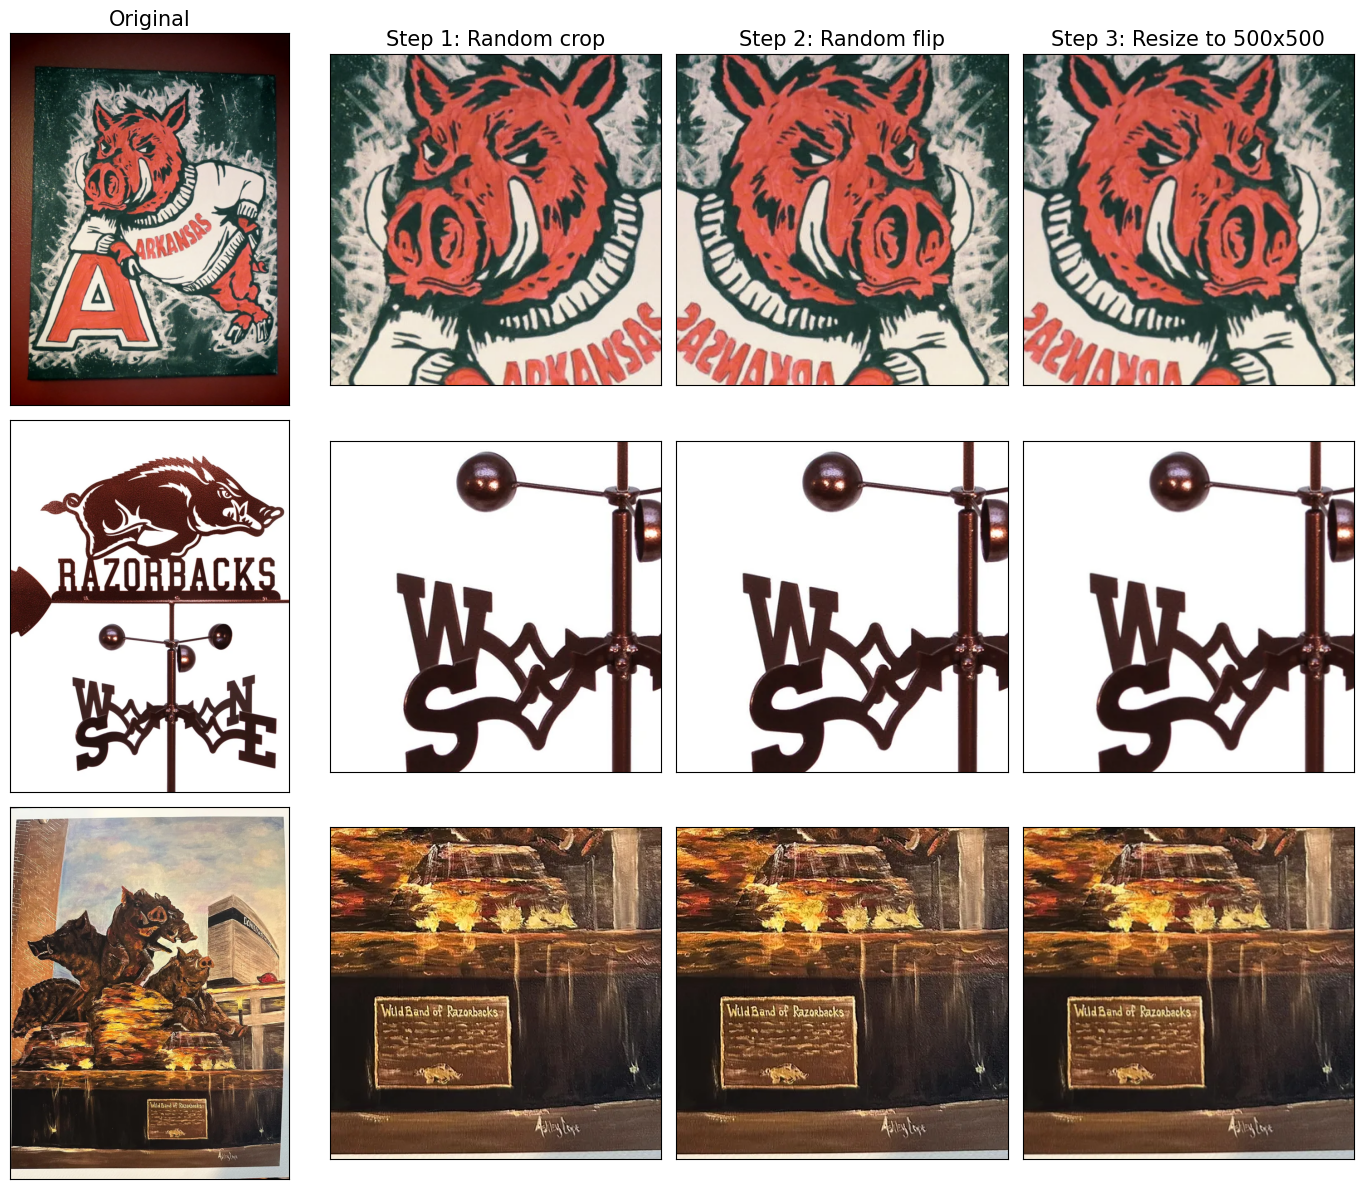

In [3]:
torch.manual_seed(1)

fig = plt.figure(figsize=(14, 12))

for i in range(3):
    img, label = initial_dataset[i]
    
    ax = fig.add_subplot(3, 4, i*4+1)
    ax.imshow(img)
    if i == 0:
        ax.set_title('Original', size=15)
    ax.set_xticks([]); ax.set_yticks([])
    
    ax = fig.add_subplot(3, 4, i*4+2)
    img_transform = transforms.Compose([transforms.RandomCrop([400, 400])])
    img_cropped = img_transform(img)
    ax.imshow(img_cropped)
    if i == 0:
        ax.set_title('Step 1: Random crop', size=15)
    ax.set_xticks([]); ax.set_yticks([])
    
    ax = fig.add_subplot(3, 4, i*4+3)
    img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
    img_flip = img_transform(img_cropped)
    ax.imshow(img_flip)
    if i == 0:
        ax.set_title('Step 2: Random flip', size=15)
    ax.set_xticks([]); ax.set_yticks([])
    
    ax = fig.add_subplot(3, 4, i*4+4)
    img_resized = transforms.functional.resize(img_flip, size=(500, 500))
    ax.imshow(img_resized)
    if i == 0:
        ax.set_title('Step 3: Resize to 500x500', size=15)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
plt.show()

In [4]:
# Define image transformations
# transform_train: Uses data augmentation (crop, flip) for training to prevent overfitting
# transform_test: Uses center crop only for validation/test (no random augmentation)
# Final resize to 500x500 as per project requirements

transform_train = transforms.Compose([
    transforms.RandomCrop([400, 400]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([500, 500]),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.CenterCrop([400, 400]),
    transforms.Resize([500, 500]),
    transforms.ToTensor(),
])

In [5]:
# Load full dataset and split into train/validation/test
# Using 70-15-15 split (train-validation-test)

torch.manual_seed(1)

full_dataset = torchvision.datasets.ImageFolder(image_path)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_indices, val_indices, test_indices = random_split(
    range(total_size), 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(1)
)

print(f'Train set: {len(train_indices)} images')
print(f'Validation set: {len(val_indices)} images')
print(f'Test set: {len(test_indices)} images')

Train set: 67 images
Validation set: 14 images
Test set: 16 images


In [6]:
# Create datasets with appropriate transforms
# Training uses augmentation, validation/test do not

from torch.utils.data import Subset

train_dataset_full = torchvision.datasets.ImageFolder(image_path, transform=transform_train)
train_dataset = Subset(train_dataset_full, train_indices.indices)

val_dataset_full = torchvision.datasets.ImageFolder(image_path, transform=transform_test)
val_dataset = Subset(val_dataset_full, val_indices.indices)

test_dataset_full = torchvision.datasets.ImageFolder(image_path, transform=transform_test)
test_dataset = Subset(test_dataset_full, test_indices.indices)

print(f'Train set: {len(train_dataset)} images')
print(f'Validation set: {len(val_dataset)} images')
print(f'Test set: {len(test_dataset)} images')

Train set: 67 images
Validation set: 14 images
Test set: 16 images


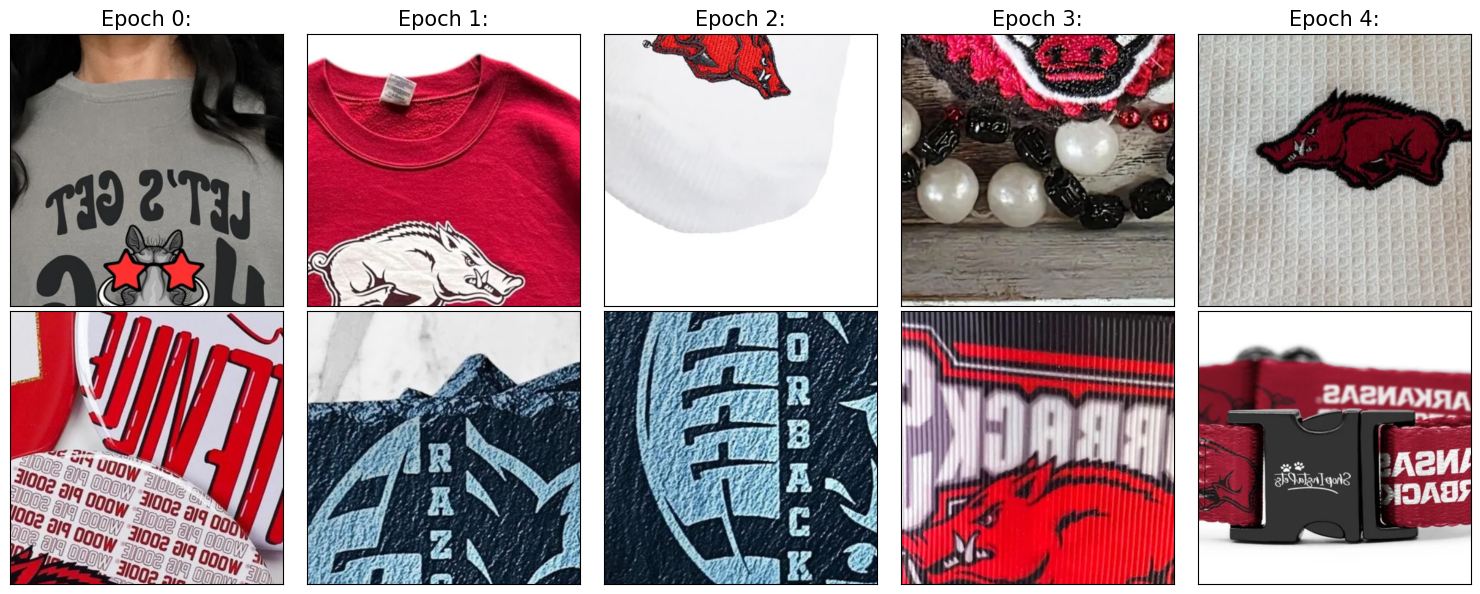

In [7]:
# Visualize augmented training samples
# Shows how random augmentation creates different versions of images across epochs

torch.manual_seed(1)

batch_size = 2
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

fig = plt.figure(figsize=(15, 6))

num_epochs = 5
for j in range(num_epochs):
    img_batch, label_batch = next(iter(data_loader))
    
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))
    
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

plt.tight_layout()
plt.show()

In [8]:
# Create data loaders for batching and shuffling

batch_size = 8

torch.manual_seed(1)
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Training batches: {len(train_dl)}')
print(f'Validation batches: {len(valid_dl)}')
print(f'Test batches: {len(test_dl)}')

Training batches: 9
Validation batches: 2
Test batches: 2


In [9]:
# Define CNN architecture
# 4 convolutional layers with increasing filters (32->64->128->256)
# ReLU activations, MaxPooling, and Dropout (p=0.5) to prevent overfitting

model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout2', nn.Dropout(p=0.5))

model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))

model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())

In [10]:
# Test model architecture with sample input to verify dimensions

x = torch.ones((4, 3, 500, 500))
model(x).shape

torch.Size([4, 256, 62, 62])

In [11]:
# Add pooling and flatten layers
# AvgPool2d reduces spatial dimensions, Flatten prepares for fully connected layer

model.add_module('pool4', nn.AvgPool2d(kernel_size=62))
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 3, 500, 500))
print('Shape after pooling and flatten:', model(x).shape)

Shape after pooling and flatten: torch.Size([4, 256])


In [12]:
# Add final classification layers
# Fully connected layer maps to single output, sigmoid converts to probability

model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())

In [13]:
# Verify final model output shape

x = torch.ones((4, 3, 500, 500))
print('Final output shape:', model(x).shape)
print('Model architecture:')
model

Final output shape: torch.Size([4, 1])
Model architecture:


Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=62, stride=62, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
# Move model to GPU if available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

model = model.to(device)

Using device: cpu


In [15]:
# Define loss function and optimizer

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
# Define training function
# Trains model for specified epochs, tracking loss and accuracy on train and validation sets

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)[:, 0]
                loss = loss_fn(pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = ((pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()
        
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1}/{num_epochs} - '
              f'Train Loss: {loss_hist_train[epoch]:.4f}, '
              f'Train Acc: {accuracy_hist_train[epoch]:.4f}, '
              f'Val Loss: {loss_hist_valid[epoch]:.4f}, '
              f'Val Acc: {accuracy_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [17]:
# Train the model

torch.manual_seed(1)

num_epochs = 25

hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1/25 - Train Loss: 0.6796, Train Acc: 0.6418, Val Loss: 0.6901, Val Acc: 0.7143
Epoch 2/25 - Train Loss: 0.6550, Train Acc: 0.7015, Val Loss: 0.6778, Val Acc: 0.7857
Epoch 3/25 - Train Loss: 0.5974, Train Acc: 0.7015, Val Loss: 0.5720, Val Acc: 0.7857
Epoch 4/25 - Train Loss: 0.6248, Train Acc: 0.7015, Val Loss: 0.6371, Val Acc: 0.7857
Epoch 5/25 - Train Loss: 0.6069, Train Acc: 0.7015, Val Loss: 0.6660, Val Acc: 0.7857
Epoch 6/25 - Train Loss: 0.5909, Train Acc: 0.7015, Val Loss: 0.5880, Val Acc: 0.7857
Epoch 7/25 - Train Loss: 0.5955, Train Acc: 0.7015, Val Loss: 0.5905, Val Acc: 0.7857
Epoch 8/25 - Train Loss: 0.5653, Train Acc: 0.7015, Val Loss: 0.6148, Val Acc: 0.7857
Epoch 9/25 - Train Loss: 0.5699, Train Acc: 0.7015, Val Loss: 0.5891, Val Acc: 0.7857
Epoch 10/25 - Train Loss: 0.5927, Train Acc: 0.7015, Val Loss: 0.6536, Val Acc: 0.7857
Epoch 11/25 - Train Loss: 0.6242, Train Acc: 0.7015, Val Loss: 0.5641, Val Acc: 0.7857
Epoch 12/25 - Train Loss: 0.5804, Train Acc: 0.7015,

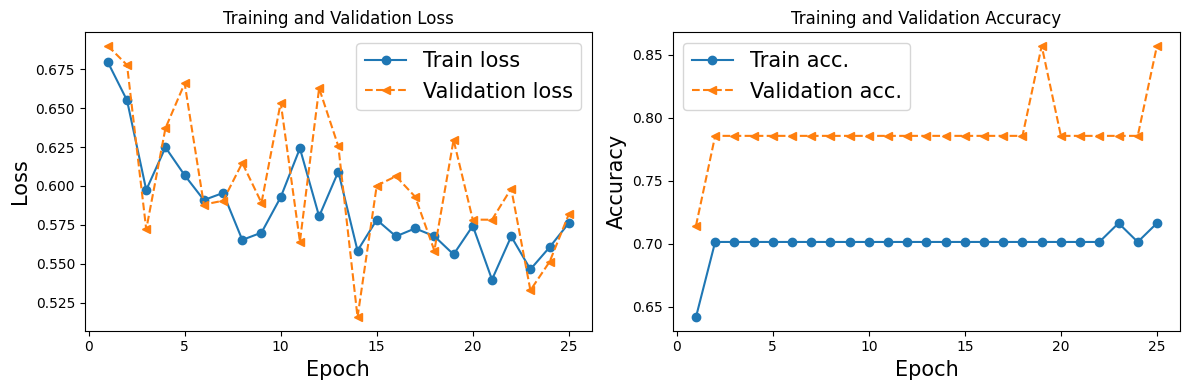

In [18]:
# Plot training history
# Loss should decrease, accuracy should increase
# Large gap between train and validation indicates overfitting

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_title('Training and Validation Loss')

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
ax.set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [19]:
# Evaluate model on test set

accuracy_test = 0

model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        is_correct = ((pred >= 0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum().cpu()

accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.8125


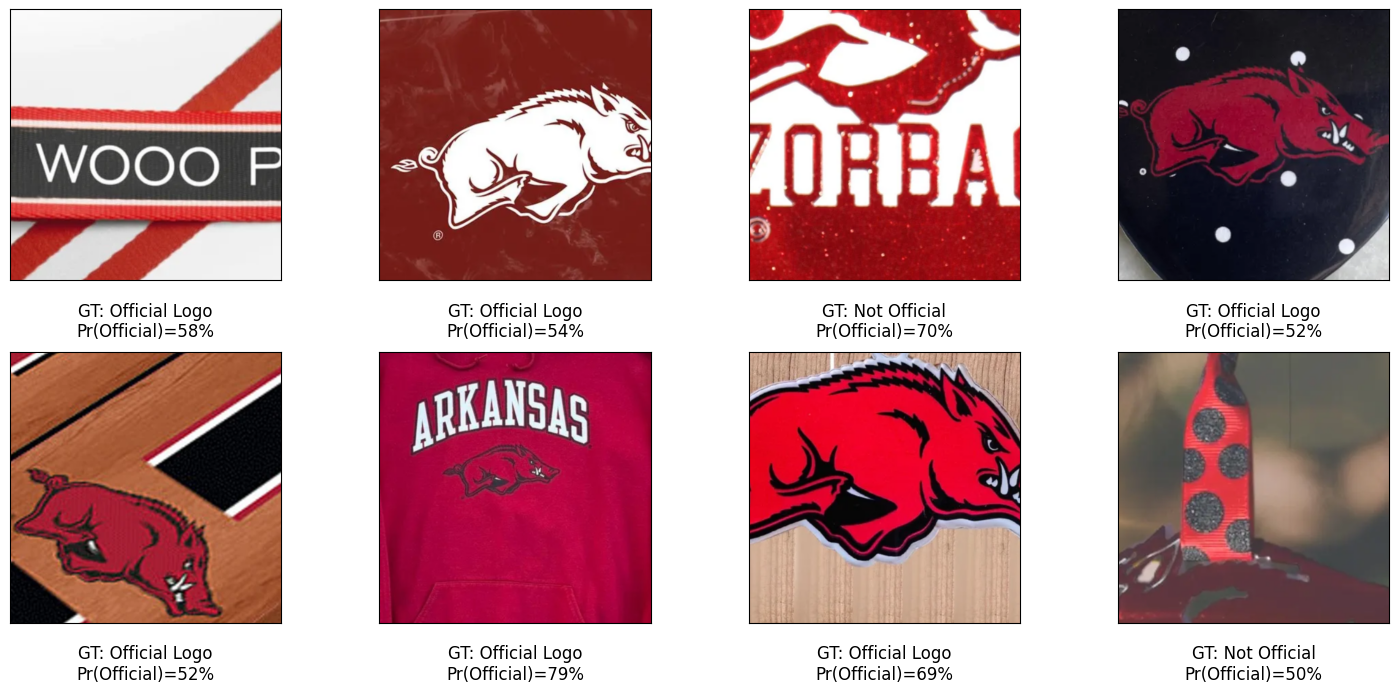

In [20]:
# Visualize predictions on test samples

x_batch, y_batch = next(iter(test_dl))
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)

pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
num_to_show = min(8, len(x_batch))

for j in range(num_to_show):
    ax = fig.add_subplot(2, 4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].cpu().permute(1, 2, 0))
    
    if y_batch[j] == 1:
        label = 'Official Logo'
    else:
        label = 'Not Official'
    
    ax.text(
        0.5, -0.15,
        f'GT: {label}\nPr(Official)={pred[j]:.0f}%',
        size=12,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )

plt.tight_layout()
plt.show()

In [21]:
# Calculate additional evaluation metrics
# Precision, Recall, F1-Score, and Confusion Matrix

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        pred = model(x_batch)[:, 0]
        pred_labels = (pred >= 0.5).float()
        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)

print(f'Test Set Evaluation Metrics:')
print(f'Accuracy: {accuracy_test:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'\nConfusion Matrix:')
print(f'                 Predicted')
print(f'                 Not  Official')
print(f'Actual Not     {cm[0][0]:4d}    {cm[0][1]:4d}')
print(f'       Official {cm[1][0]:4d}    {cm[1][1]:4d}')

Test Set Evaluation Metrics:
Accuracy: 0.8125
Precision: 0.7857
Recall: 1.0000
F1-Score: 0.8800

Confusion Matrix:
                 Predicted
                 Not  Official
Actual Not        2       3
       Official    0      11


In [22]:
# Save the trained model

import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/Group_21_CNN_FullModel.ph'

torch.save(model, path)
print(f'Model saved to {path}')

Model saved to models/Group_21_CNN_FullModel.ph


In [23]:
# Load and test the saved model

path = 'models/Group_21_CNN_FullModel.ph'

loaded_full_model = torch.load(path, weights_only=False)
loaded_full_model.eval()

print('Model loaded successfully!')

Model loaded successfully!
